In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from dateutil.relativedelta import relativedelta

## Descarga de precios

In [4]:
fecha_inicial = "2014-11-1" # Inclusivo
fecha_final = "2024-11-1" # Exclusivo
ticker = "CSPX.L"

In [5]:
precios = yf.download(ticker, fecha_inicial, fecha_final)["Adj Close"]

[*********************100%***********************]  1 of 1 completed


In [6]:
rango_fechas = precios.index

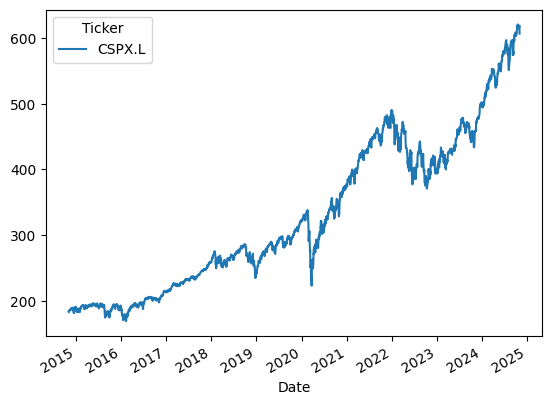

In [7]:
precios.plot()
plt.show()

In [8]:
retornos = np.log(precios).diff().fillna(0)

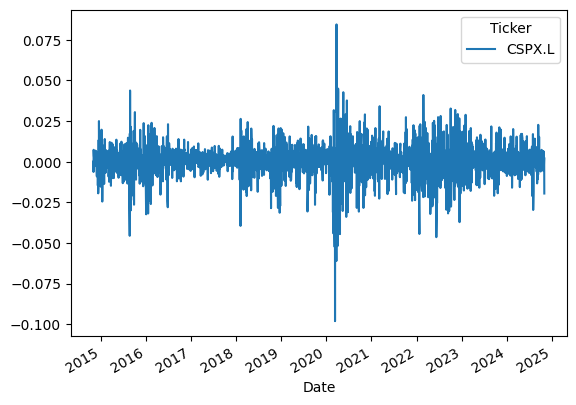

In [9]:
retornos.plot()
plt.show()

## Aportes a FPV
Se asume un salario neto de COP 10M. La mínima base gravable son COP 6M, la cual se puede lograr con un aporte a FPV del 20% del salario neto y aprovechar el beneficio del 25% de renta exenta sobre los 8M restantes.

$(10M - 2M) * (1 - 0.25) = 6M$

A 2024, la retención de los dos escenarios sería la siguiente:
- Aporte a FPV: base de 6M y retención de 290 mil.
- No aportes: base de 7,5M por el beneficio del 25% sobre los 10M, retención de 594 mil.

In [37]:
inversion_fpv = 2_000_000
retencion_fpv = 290_000
retencion = 594_000
inversion = inversion_fpv - retencion + retencion_fpv - 35_000
print(inversion)

1661000


La inversión en el escenario con aportes a FPV es COP 2M, y la inversión en el escenario sin aportes, donde se pierde el beneficio tributario, es de COP 1,661M. Se resta un monto adicional como compensación mensual por el mayor impuesto de renta a pagar el siguiente año.

In [38]:
df = pd.DataFrame({
    "precios": precios[ticker].copy(),
    "retornos": retornos[ticker].copy(),
    "retornos_acum": np.nan,
    "inversion": np.nan
    }, index=precios.index)
df["retornos_acum"] = df["retornos"].cumsum()

## Comisiones FPV
Se asumen diferentes comisiones acorde a lo que hoy se encuentra en el mercado (2% - 3.5%).

In [39]:
col_nombres = ["inversion_fpv_3.5", "inversion_fpv_3.0", "inversion_fpv_2.5", "inversion_fpv_2.0"]

In [40]:
comision_fpv = np.array([0.035, 0.03, 0.025, 0.02])
comision_fpv = (1 + comision_fpv)**(1 / 252) - 1 # comisión diaria
df[col_nombres] = np.nan

## Comparación Inversión FPV vs. Normal
Se asume una comisión de compra + venta de 1% en la inversión normal que es aproximadamente lo que se puede conseguir en brókers nacionales con los montos de inversión supuestos.

In [41]:
df.loc[rango_fechas[0], "inversion"] = inversion * (1 - 0.01)
df.loc[rango_fechas[0], col_nombres] = inversion_fpv
display(df)

,precios,retornos,retornos_acum,inversion,inversion_fpv_3.5,inversion_fpv_3.0,inversion_fpv_2.5,inversion_fpv_2.0
Date,,,,,,,,
2014-11-03,183.845001,0.000000,0.000000,1644390.0,2000000.0,2000000.0,2000000.0,2000000.0
2014-11-04,182.679993,-0.006357,-0.006357,NaN,NaN,NaN,NaN,NaN
2014-11-05,184.014999,0.007281,0.000924,NaN,NaN,NaN,NaN,NaN
2014-11-06,184.789993,0.004203,0.005127,NaN,NaN,NaN,NaN,NaN
2014-11-07,185.449997,0.003565,0.008692,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-10-25,618.500000,0.006358,1.213204,NaN,NaN,NaN,NaN,NaN
2024-10-28,616.950012,-0.002509,1.210695,NaN,NaN,NaN,NaN,NaN
2024-10-29,616.909973,-0.000065,1.210630,NaN,NaN,NaN,NaN,NaN


In [42]:
for i, fecha in enumerate(rango_fechas[1:], 1):
    df.loc[fecha, "inversion"] = df["inversion"].iloc[i - 1] * np.exp(df["retornos"].iloc[i])
    df.loc[fecha, "inversion_fpv_3.5"] = df["inversion_fpv_3.5"].iloc[i - 1] * np.exp(df["retornos"].iloc[i]) * (1 - comision_fpv[0])
    df.loc[fecha, "inversion_fpv_3.0"] = df["inversion_fpv_3.0"].iloc[i - 1] * np.exp(df["retornos"].iloc[i]) * (1 - comision_fpv[1])
    df.loc[fecha, "inversion_fpv_2.5"] = df["inversion_fpv_2.5"].iloc[i - 1] * np.exp(df["retornos"].iloc[i]) * (1 - comision_fpv[2])
    df.loc[fecha, "inversion_fpv_2.0"] = df["inversion_fpv_2.0"].iloc[i - 1] * np.exp(df["retornos"].iloc[i]) * (1 - comision_fpv[3])

In [43]:
df.tail(10)

,precios,retornos,retornos_acum,inversion,inversion_fpv_3.5,inversion_fpv_3.0,inversion_fpv_2.5,inversion_fpv_2.0
Date,,,,,,,,
2024-10-18,620.119995,-0.000596,1.215820,5.546624e+06,4.784837e+06,5.021927e+06,5.271995e+06,5.535820e+06
2024-10-21,616.900024,-0.005206,1.210614,5.517823e+06,4.759342e+06,4.995265e+06,5.244106e+06,5.506642e+06
2024-10-22,618.159973,0.002040,1.212654,5.529093e+06,4.768412e+06,5.004880e+06,5.254302e+06,5.517455e+06
2024-10-23,614.630005,-0.005727,1.206927,5.497519e+06,4.740535e+06,4.975716e+06,5.223785e+06,5.485517e+06
2024-10-24,614.580017,-0.000081,1.206846,5.497072e+06,4.739502e+06,4.974728e+06,5.222849e+06,5.484640e+06
2024-10-25,618.500000,0.006358,1.213204,5.532134e+06,4.769081e+06,5.005871e+06,5.255647e+06,5.519189e+06
2024-10-28,616.950012,-0.002509,1.210695,5.518270e+06,4.756480e+06,4.992740e+06,5.241962e+06,5.504925e+06
2024-10-29,616.909973,-0.000065,1.210630,5.517912e+06,4.755522e+06,4.991830e+06,5.241108e+06,5.504135e+06
2024-10-30,618.460022,0.002509,1.213140,5.531777e+06,4.766820e+06,5.003786e+06,5.253762e+06,5.517531e+06


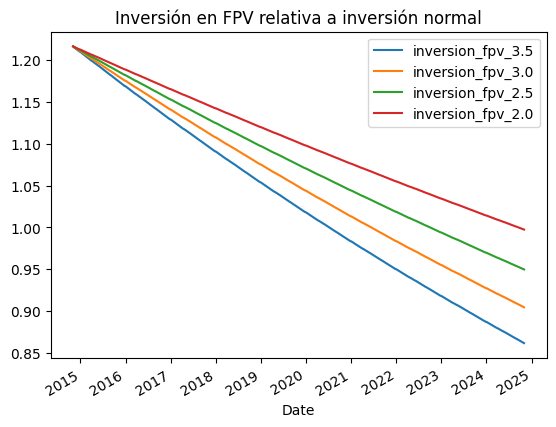

In [44]:
(df[col_nombres].div(df["inversion"], axis=0)).plot()
plt.title("Inversión en FPV relativa a inversión normal")
plt.show()

## Tiempo en años donde la inversión en los FPV es mayor según su comisión.

In [45]:
fechas_under = [df.loc[df["inversion"] > df[com]].index[0] for com in col_nombres]

In [46]:
diferencia_fechas = [relativedelta(fechas_under[i], df.index[0]) for i in range(len(fechas_under))]

In [47]:
diferencia_yr = [
    diferencia_fechas[i].years + diferencia_fechas[i].months / 12 + diferencia_fechas[i].days / 365 for i in range(len(fechas_under))
]

In [48]:
for idx, dif in enumerate(diferencia_yr):
    print(f"La inversión en FPV es mayor por {round(dif, 2)} años con una comisión de {round(((1 + comision_fpv[idx])**252 - 1)*100, 2)}%")

La inversión en FPV es mayor por 5.68 años con una comisión de 3.5%
La inversión en FPV es mayor por 6.61 años con una comisión de 3.0%
La inversión en FPV es mayor por 7.91 años con una comisión de 2.5%
La inversión en FPV es mayor por 9.87 años con una comisión de 2.0%
